# Document Similarity w/o Attention

In [1]:
from __future__ import division, print_function
from keras.callbacks import ModelCheckpoint
from keras.layers import Input
from keras.layers.core import Dense, Dropout
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import GRU
from keras.layers.merge import concatenate
from keras.models import Model, load_model
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.layers.wrappers import Bidirectional
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import nltk
import numpy as np
import os
%matplotlib inline

Using TensorFlow backend.


In [2]:
DATA_DIR = "../data"
TRAIN_DIR = os.path.join(DATA_DIR, "train")
TEST_DIR = os.path.join(DATA_DIR, "test-gold")

DATA_SOURCES = ["MSRpar", "MSRvid", "SMTeuroparl"]
SPAIR_FILE_TPL = "STS.input.{:s}.txt"
LABEL_FILE_TPL = "STS.gs.{:s}.txt"

VOCAB_FILE = os.path.join(DATA_DIR, "sts-vocab.tsv")

GLOVE_FILE = os.path.join(DATA_DIR, "glove.840B.300d.txt")

BEST_MODEL = os.path.join(DATA_DIR, "06a-best-model.h5")

MIN_OCCURS = 2
MAX_WORDS = 35

WORD_EMBED_SIZE = 300
SENT_EMBED_SIZE = 100

NUM_CLASSES = 6

BATCH_SIZE = 64
NUM_EPOCHS = 10

## Load Vocabulary

In [3]:
word2id = {"PAD": 0, "UNK": 1}
fvocab = open(VOCAB_FILE, "rb")
for i, line in enumerate(fvocab):
    word, count = line.strip().split("\t")
    if int(count) < MIN_OCCURS:
        break
    word2id[word] = i
fvocab.close()
id2word = {v:k for k, v in word2id.items()}
vocab_size = len(word2id)
print("vocab_size: {:d}".format(vocab_size))

vocab_size: 6942


## Load GloVe Embeddings

In [4]:
E = np.zeros((vocab_size, WORD_EMBED_SIZE))
E[1] = np.random.random(WORD_EMBED_SIZE)
fglove = open(GLOVE_FILE, "rb")
for line in fglove:
    cols = line.strip().split(" ")
    word = cols[0]
    if not word2id.has_key(word):
        continue
    vec = np.array([float(x) for x in cols[1:]])
    idx = word2id[word]
    E[idx] = vec
fglove.close()
print(E.shape)

(6942, 300)


## Compute Input Sequences

In [5]:
def convert_to_sequence(sent, word2id):
    int_seq = []
    sent = sent.decode("utf8").encode("ascii", "ignore").lower()
    for word in nltk.word_tokenize(sent):
        if word2id.has_key(word):
            int_seq.append(word2id[word])
        else:
            int_seq.append(word2id["UNK"])
    return int_seq
    
def load_data(datadir, word2id, max_words):
    xleft, xright, ys = [], [], []
    for data_source in DATA_SOURCES:
        label_filename = LABEL_FILE_TPL.format(data_source)
        flabel = open(os.path.join(datadir, label_filename))
        for line in flabel:
            ys.append(float(line.strip()))
        flabel.close()
        # sentence pairs
        spair_filename = SPAIR_FILE_TPL.format(data_source)
        fsents = open(os.path.join(datadir, spair_filename))
        for line in fsents:
            left, right = line.strip().split("\t")
            xleft.append(convert_to_sequence(left, word2id))
            xright.append(convert_to_sequence(right, word2id))
        fsents.close()
        assert len(xleft) == len(xright) and len(xright) == len(ys)
    Xleft = np.array(pad_sequences(xleft, maxlen=max_words))
    Xright = np.array(pad_sequences(xright, maxlen=max_words))
    Y = to_categorical(np.array(ys, dtype="int32"), 
                       num_classes=NUM_CLASSES)
    return Xleft, Xright, Y
    
Xtrain_l, Xtrain_r, Ytrain = load_data(TRAIN_DIR, word2id, MAX_WORDS)
Xtest_l, Xtest_r, Ytest = load_data(TEST_DIR, word2id, MAX_WORDS)

print(Xtrain_l.shape, Xtrain_r.shape, Ytrain.shape)
print(Xtest_l.shape, Xtest_r.shape, Ytest.shape)

(2234, 35) (2234, 35) (2234, 6)
(1959, 35) (1959, 35) (1959, 6)


## Define Network

### Sentence Processing

In [6]:
sent_in = Input(shape=(MAX_WORDS, ), dtype="int32")

sent_emb = Embedding(input_dim=vocab_size,
                     output_dim=WORD_EMBED_SIZE,
                     weights=[E])(sent_in)
sent_enc = Bidirectional(GRU(SENT_EMBED_SIZE,
                             return_sequences=False))(sent_emb)

sent_model = Model(inputs=sent_in, outputs=sent_enc)
sent_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 35)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 35, 300)           2082600   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 200)               240600    
Total params: 2,323,200
Trainable params: 2,323,200
Non-trainable params: 0
_________________________________________________________________


### Full Network

In [7]:
sim_in_l = Input(shape=(MAX_WORDS,))
sim_in_r = Input(shape=(MAX_WORDS,))

sim_enc_l = sent_model(sim_in_l)
sim_enc_r = sent_model(sim_in_r)

sim_mrg = concatenate([sim_enc_l, sim_enc_r], axis=1)

sim_fc1d = Dropout(0.2)(sim_mrg)
sim_fc1 = Dense(50, activation="relu")(sim_fc1d)
sim_fc2d = Dropout(0.2)(sim_fc1)
sim_pred = Dense(NUM_CLASSES, activation="softmax")(sim_fc2d)

model = Model(inputs=[sim_in_l, sim_in_r], outputs=[sim_pred])
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_2 (InputLayer)             (None, 35)            0                                            
____________________________________________________________________________________________________
input_3 (InputLayer)             (None, 35)            0                                            
____________________________________________________________________________________________________
model_1 (Model)                  (None, 200)           2323200     input_2[0][0]                    
                                                                   input_3[0][0]                    
____________________________________________________________________________________________________
concatenate_1 (Concatenate)      (None, 400)           0           model_1[1][0]           

In [8]:
model.compile(loss="categorical_crossentropy", optimizer="adam",
              metrics=["accuracy"])

In [9]:
checkpoint = ModelCheckpoint(filepath=BEST_MODEL, save_best_only=True)
history = model.fit([Xtrain_l, Xtrain_r], Ytrain, 
                    batch_size=BATCH_SIZE,
                    epochs=NUM_EPOCHS,
                    validation_split=0.1,
                    callbacks=[checkpoint])

/Users/palsujit/anaconda2/lib/python2.7/site-packages/Keras-2.0.4-py2.7.egg/keras/backend/tensorflow_backend.py:2252: UserWarning: Expected no kwargs, you passed 1
kwargs passed to function are ignored with Tensorflow backend
  warnings.warn('\n'.join(msg))


Train on 2010 samples, validate on 224 samples
Epoch 1/10
2010/2010 [==============================] - 10s - loss: 1.5944 - acc: 0.3512 - val_loss: 1.2300 - val_acc: 0.6562

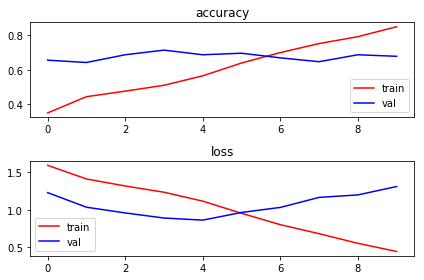

In [10]:
plt.subplot(211)
plt.title("accuracy")
plt.plot(history.history["acc"], color="r", label="train")
plt.plot(history.history["val_acc"], color="b", label="val")
plt.legend(loc="best")

plt.subplot(212)
plt.title("loss")
plt.plot(history.history["loss"], color="r", label="train")
plt.plot(history.history["val_loss"], color="b", label="val")
plt.legend(loc="best")

plt.tight_layout()
plt.show()

## Evaluate Network

In [11]:
best_model = load_model(BEST_MODEL)
Ytest_ = best_model.predict([Xtest_l, Xtest_r])

ytest = np.argmax(Ytest, axis=1)
ytest_ = np.argmax(Ytest_, axis=1)

np.set_printoptions(linewidth=120)
print("accuracy score: {:.3f}".format(accuracy_score(ytest, ytest_)))
print("\nconfusion matrix\n")
print(confusion_matrix(ytest, ytest_))

accuracy score: 0.424

confusion matrix

[[211   3   3  12   1   0]
 [ 86   9  14  51   6   0]
 [ 85   4  22 118  16   1]
 [116   1  28 341  92   4]
 [ 80   0  13 168 215  33]
 [ 36   0   2  66  90  32]]
